# Modèle SVM
## Imports

In [5]:
import findspark
findspark.init()
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, DateType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, CountVectorizer, NGram, VectorAssembler, ChiSqSelector
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## Variables contexte

In [6]:
spark1 = SparkSession.builder\
            .master("local[*]")\
            .appName("SVM_Twitter")\
            .getOrCreate()

In [7]:
path = "../resources/training_noemoticon.csv"

schema = StructType([
    StructField("target", IntegerType(), True),
    StructField("id", StringType(), True),
    StructField("date", StringType(), True),
    StructField("query", StringType(), True),
    StructField("author", StringType(), True),
    StructField("tweet", StringType(), True)])

## Récupération du dataset et séparation train et test

In [8]:
df = spark1.read.csv(path,
                     inferSchema=True,
                     header=False,
                     schema=schema)

df.dropna()

(train_set, test_set) = df.randomSplit([0.80, 0.20], seed = 2000)

## Création de la pipeline

In [9]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features")
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

svm = LinearSVC()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, svm])

In [12]:
%%time
pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7574188837505382
Precision: 0.757421933550743
Recall: 0.7574188837505382
CPU times: total: 31.2 ms
Wall time: 1min 33s


## HashingTF - IDF (paramètres customisés)

In [ ]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

svm = LinearSVC()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, svm])

In [ ]:
%%time
pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

## CountVectorizer - IDF (paramètres par défaut)

In [ ]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features")

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

svm = LinearSVC()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, svm])

In [ ]:
%%time
pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

## CountVectorizer - IDF (paramètres customisés)

In [ ]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

svm = LinearSVC()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, svm])

In [ ]:
%%time
pipelineFit = pipeline.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# CountVectorizer + NGram + ChisQSelector

In [ ]:
def build_trigrams(inputCol=["tweet","target"], n=3):
    
    tokenizer = [Tokenizer(inputCol="tweet", outputCol="words")]
    
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    
    svm = [LinearSVC()]
    
    return Pipeline(stages=tokenizer + ngrams + cv + idf + assembler + label_stringIdx + selector + svm)

In [ ]:
%%time
pipelineFit = build_trigrams().fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

## Cross-Validation 10-fold

In [ ]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

svm = LinearSVC()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, svm])

In [ ]:
param_grid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.001, 0.01, 0.1, 1, 10, 100]) \
    .build()
    
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=10)

In [ ]:
%%time
pipelineFit = cv.fit(train_set)

predictions = pipelineFit.transform(test_set)

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

bestModel = pipelineFit.bestModel
pipelineFit.getEstimatorParamMaps()[np.argmax(pipelineFit.avgMetrics)]

## Stats

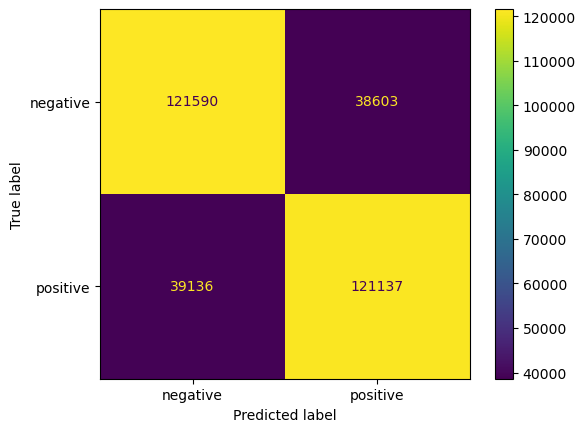

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=[0.0, 1.0], display_labels=["negative", "positive"])